In [3]:
import tensorquant as tq
from datetime import date
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date

# Settings

In [21]:
tq.Settings.evaluation_date = date(2024, 7, 31)

calendar = tq.TARGET()
daycounter = tq.DayCounter(tq.DayCounterConvention.Actual360)
evaluation_date = tq.Settings.evaluation_date

# Market

In [22]:
mkt = pd.read_excel("data/market_20240731.xlsx")
mkt['start'] = mkt['start'].dt.date
mkt['end'] = mkt['end'].dt.date
estr_df = mkt[mkt['name'] == 'EUR_ESTR']
eur6m_df = mkt[mkt['name'] == 'EUR_6M']

rates_estr = estr_df['quote'].values/100
times_estr = [daycounter.day_count(evaluation_date, d) for d in estr_df['end']]

rates_6m = eur6m_df['quote'].values/100
times_6m = [daycounter.day_count(evaluation_date, d) for d in eur6m_df['end']]

market_data = {}
market_data["IR:EUR:ESTR"] = tq.RateCurve(reference_date=evaluation_date,
                                        pillars=estr_df['end'],
                                        rates=rates_estr,
                                        interp='LINEAR',
                                        daycounter_convention=tq.DayCounterConvention.ActualActual)
market_data["IR:EUR:6M"] = tq.RateCurve(reference_date=evaluation_date,
                                        pillars=eur6m_df['end'],
                                        rates=rates_6m,
                                        interp='LINEAR',
                                        daycounter_convention=tq.DayCounterConvention.ActualActual)
eur6m_index = tq.IborIndex(calendar, 6, tq.TimeUnit.Months, tq.Currency.EUR, 2)
eur6m_index.add_fixing(evaluation_date, 0.03)

# Deposit

A zero-coupon bond in which a counterparty lends a nominal amount \(N\) to another counterparty, which at maturity pays the notional amount plus the $r_{ois}(t,t+1)$ rate accrued over this period. The payoff is given by

$$
\phi_{\text{Deposit}}(t+1) = N(1 + r_{ois}(t,t+1)\tau_{\text{1day}})
$$

and its \(t\)-value is

$$
\begin{split}
\phi_{\text{Deposit}}(t) &= P_d(t,t+1)\mathbb{E}^{t+1}\left[\frac{\phi_{\text{Deposit}}(t+1)}{P_d(t+1,t+1)}\right] \\
&= N P_d(t,t+1)(1 + r_{ois}(t,t+1)\tau_{\text{1day}}) = N
\end{split}
$$

Following that

$$
P_d(t,T_i) = \frac{1}{1 + r_{ois}(t,T_i) \tau_i}
$$


In [23]:
spot_date = calendar.advance(evaluation_date, 2, tq.TimeUnit.Days, tq.DayCounterConvention.Actual360)
maturity = calendar.advance(spot_date, 1, tq.TimeUnit.Days, tq.DayCounterConvention.Actual360)
quote = 0.03

deposit = tq.Deposit(ccy=tq.Currency.EUR,
                    rate=quote,
                    trade_date=evaluation_date,
                    start_date=spot_date,
                    end_date=maturity,
                    notional=100,
                    day_count_convention=tq.DayCounterConvention.Actual360)
depo_engine = tq.DepositPricer(tq.market_map)
depo_engine.price(deposit, market_data, True)
sensy_depo = depo_engine.tape.gradient(deposit.price, market_data["IR:EUR:ESTR"]._rates)

# results
sensy_depo = pd.DataFrame([market_data["IR:EUR:ESTR"]._pillars, sensy_depo]).T
sensy_depo.columns = ['time', 'sensy']
sensy_depo.fillna(0, inplace = True)
sensy_depo.set_index('time', inplace = True)
sensy_depo['sensy'] = sensy_depo['sensy'].apply(tq.extract_value)
sensy_depo[sensy_depo['sensy'] != 0]


sensy
time              
0.005464 -0.546835
0.013661  1.363827
0.024590  0.004690

# Forward Rate Agreement

A multi-curve FRA is a contract in which two parties agree, in $t$, on the financing rate for a period $(T_n,T_S)$, the standard market FRA exchanges the cash flow in $T_n$, which, since it's an uncollateralized financing, is the same payoff that would be exchanged at the end of the period $(T_S)$ but discounted by $[1+\tau_{6m}F_{6m}(t,T_n,T_S)]^{-1}$. Hence, the corresponding FRA rate, $F_x(t,T_n,T_S)$, can be considered as the fixed rate to exchange in $T_S$ against the Libor rate $L_x(T_n,T_S)$ such that the $t$-value of a corresponding *one-cash-flow* swap is zero.  

FRA contracts are nowadays, in most cases, regulated by a CSA, so if we stress a bit the reality, assuming continuous mark-to-market and collateral posting, and that it covers 100\% of the contract's present value, then we could in fact neglect counterparty default risk, and discount our cash flow using the risk-free discount factor $P_d(t,T_n)$. Hence, the $t$-value of the FRA will be given by

$$
FRA_{6m} = P_d(t,T_n) \frac{k - F_{6m}(t,T_n,T_S)}{1 + \tau_{6m}F_{6m}(t,T_n,T_S)} \tau_{6m}
$$

where the FRA rate, $k$, that makes the contract fair, is given by

$$
k = F_{6m}(t,T_n,T_S) = \frac{1}{\tau_{6m}} \left( \frac{P_{6m}(t,T_n)}{P_{6m}(t,T_S)} - 1 \right)
$$

and $P_{6m}(t,T_n)$ is the unitary zero-coupon bond associated with $r_{6m}(t,T_n)$: $$P_{6m}(t,T_n) = e^{-\int_t^{T_n} r_{6m}(s,s+6m) ds} = e^{r_{6m}(t,T_n)(T_n-t)}$$


In [24]:
notional=100e6
fixed_rate = 0.01

eur_fra_builder = tq.FraGenerator(ccy=tq.Currency.EUR,
                                  start_delay=2,
                                  fixing_days=2,#TODO a che serve??
                                  index_term="6M",
                                  roll_convention= tq.BusinessDayConvention.ModifiedFollowing,
                                  notional=notional,
                                  day_count_convention=tq.DayCounterConvention.Actual360,
                                  calendar=calendar,
                                  index=eur6m_index)  
fra = eur_fra_builder.build(trade_date=evaluation_date, quote=fixed_rate, term="3M-9M")

In [25]:
fra_engine = tq.FraPricer(tq.market_map)
fra_engine.price(fra, market_data, True)
tape = fra_engine.tape
print(f"NPV FRA: {fra.price :,.0f}")

NPV FRA: 896,751


# OIS

$$
\begin{split}
SWAP_{OIS}(t, T_n, T_S, k) 
&= FIX_{OIS}(t, T_n, T_S, k) - FLT_{OIS}(t, T_n, T_S) \\
&= k \sum_{j=n+1}^{S} \tau_j P_d(t, T_j) - [P_d(t, T_n) - P_d(t, T_S)] \\
&= k A_{d,n,s}(t) - [P_d(t, T_n) - P_d(t, T_S)]
\end{split}
$$

Where $A_{d,n,s}(t)$ is called the *annuity factor*. From here, it's easy to derive the value of $k$ which makes the SWAP fair in $t$, i.e., the fixed rate such that $SWAP_{OIS}(t, T_n, T_S, k) = 0$, the so-called SWAP rate, given by

$$
k = S_{n,S}(t) = \frac{P_d(t, T_n) - P_d(t, T_S)}{A_{d,n,s}(t)}
$$


In [26]:
estr_index = tq.OvernightIndex(calendar, tq.Currency.EUR)

eur_ois_builder = tq.OisGenerator(
                        ccy=tq.Currency.EUR,
                        start_delay=2,
                        fixing_days=2,
                        period_fix="1Y",
                        period_flt="1Y",
                        roll_convention= tq.BusinessDayConvention.ModifiedFollowing,
                        notional=100e6,
                        day_count_convention_fix= tq.DayCounterConvention.Actual360,
                        day_count_convention_flt= tq.DayCounterConvention.Actual360,
                        calendar=calendar,
                        index= estr_index)

fixed_rate = 0.01
ois = eur_ois_builder.build(trade_date=evaluation_date, quote=fixed_rate, term="5Y")

In [27]:
ois_engine = tq.OisPricer(tq.market_map)
# npv_ois, tape = ois_engine.price(ois, evaluation_date, market_data, True)
ois_engine.price(ois, market_data, True)
sensitivities = ois_engine.tape.gradient(ois.price, [market_data['IR:EUR:ESTR']._rates, market_data['IR:EUR:6M']._rates])

print(f"NPV FixedLeg: {ois.fixed_leg.price :,.0f}")
print(f"NPV FloatingLeg: {ois.floating_leg.price :,.0f}")
# ########
print(f"NPV OIS: {ois.price :,.0f}")

NPV FixedLeg: -4,703,160
NPV FloatingLeg: 11,375,789
NPV OIS: 6,672,629


# Vanilla Swap

$$
\begin{split}
Swap_{6m}(t, T_a, T_b, K) 
&= FIX(t, T_a, T_b, K) - FLT_{6m}(t, T_a, T_b) \\ 
&= K \sum_{k=a+1}^{b} \tau_k P_d(t, T_k) - \sum_{k=a+1}^{b} \tau_k P_d(t, T_k) F_{6m}(t, T_a, T_b) \\
&= K A_{a,b}(t) - \sum_{k=a+1}^{b} \tau_k P_d(t, T_k) F_{6m}(t, T_a, T_b)
\end{split}
$$

And the strike, $K$, that makes the SWAP fair will be

$$
K = \frac{\sum_{k=a+1}^{b} \tau_k P_d(t, T_k) F_{6m}(t, T_a, T_b)}{A_{a,b}(t)}
$$


In [28]:
currency = tq.Currency.EUR
mod_fol_convention = tq.BusinessDayConvention.ModifiedFollowing
daycount_fix = tq.DayCounterConvention.Actual360
daycount_flt = tq.DayCounterConvention.Actual360

settlement_delay = 2 
period_fixed_leg = "1Y"
period_float_leg = "6M"

irs_eur6m_generator = tq.SwapGenerator(currency, settlement_delay, period_fixed_leg, period_float_leg, mod_fol_convention, 100e6, daycount_fix, daycount_flt, calendar, eur6m_index)
fixed_rate = 0.01
swap = irs_eur6m_generator.build(trade_date=evaluation_date, quote=0.01, term="10Y")

In [29]:
swap_engine = tq.SwapPricer(tq.market_map)
swap_engine.price(swap, market_data, True)
sensitivities = swap_engine.tape.gradient(swap.price, [market_data['IR:EUR:ESTR']._rates, market_data['IR:EUR:6M']._rates])

print(f"NPV FixedLeg: {swap.fixed_leg.price :,.0f}")
print(f"NPV FloatingLeg: {swap.floating_leg.price :,.0f}")
########
print(f"NPV Swap: {swap.price :,.0f}")

NPV FixedLeg: -8,878,357
NPV FloatingLeg: 22,692,311
NPV Swap: 13,813,954


# Automatic Adjoint Differentiation (AAD) 

Consider a calculation represented by the function $F: \mathbb{R}^n \rightarrow \mathbb{R}$ that produces a scalar result $z$ out of an input $X$ in dimension $n$. Assume $F$ may be broken down into a sequence of sub-calculations $G: \mathbb{R}^n \rightarrow \mathbb{R}^m$, $K: \mathbb{R}^m \rightarrow \mathbb{R}^p$, and $H: \mathbb{R}^p \rightarrow \mathbb{R}$, such that:

$$
F(X) = H\{K[G(X)]\}
$$

where $G$, $K$, and $H$ are simple enough that their Jacobians are known analytically.

Jacobian matrices of $F$, $G$, $K$, and $H$ are related by the chain rule:

$$
\left( \frac{\partial F}{\partial X} \right)^T_{n \times 1} = \left( \frac{\partial G}{\partial X} \right)^T_{n \times m} \left( \frac{\partial K}{\partial Y} \right)^T_{m \times p} \left( \frac{\partial H}{\partial Z} \right)^T_{p \times 1}
$$

Because matrix products are associative, we can also accumulate the differentials in reverse order:

$$
\left( \frac{\partial F}{\partial X} \right)^T_{n \times 1} = \left( \frac{\partial G}{\partial X} \right)^T_{n \times m} \left[ \left( \frac{\partial K}{\partial Y} \right)^T_{m \times p} \left( \frac{\partial H}{\partial Z} \right)^T_{p \times 1} \right]_{m \times 1}
$$


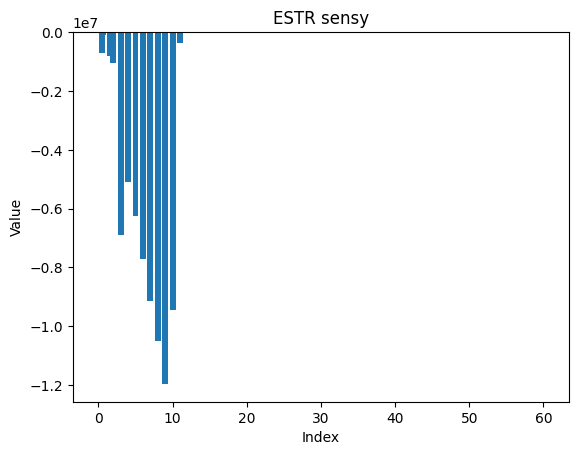

In [30]:
sensy_estr = pd.DataFrame([market_data['IR:EUR:ESTR']._pillars, sensitivities[0]]).T
sensy_estr.columns = ['time', 'sensy_estr']
sensy_estr.fillna(0., inplace = True)
sensy_estr.set_index('time', inplace = True)
sensy_estr['sensy_estr'] = sensy_estr['sensy_estr'].apply(tq.extract_value)

sensy_eur6m = pd.DataFrame([market_data['IR:EUR:6M']._pillars, sensitivities[1]]).T
sensy_eur6m.columns = ['time', 'sensy_eur6m']
sensy_eur6m.fillna(0, inplace = True)
sensy_eur6m.set_index('time', inplace = True)
sensy_eur6m['sensy_eur6m'] = sensy_eur6m['sensy_eur6m'].apply(tq.extract_value)

plt.bar(sensy_estr.index, sensy_estr['sensy_estr'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('ESTR sensy')
plt.show()